In [1]:
import os
from tvb.simulator.lab import *
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
LOG = get_logger('demo')
import pickle as cPickle
from tvb.simulator.models.stefanescu_jirsa import ReducedSetHindmarshRose
from os.path import join as pjoin

/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/tvb/datatypes/surfaces.py:60: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


### General workflow of data analyses

1. load fmri simulation
2. calculate the fc then calculate the correlation between simulated fc and empirical fc
3. save the correlation coefficient then plot the correlation trajectory for each participant
4. visualize the results

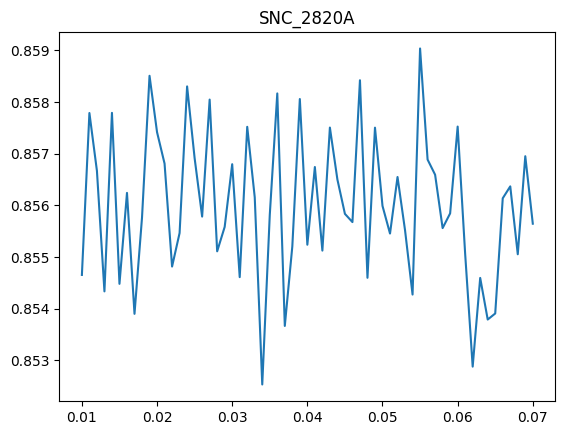

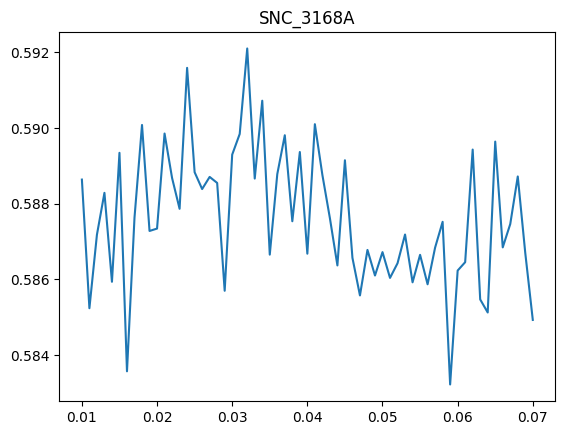

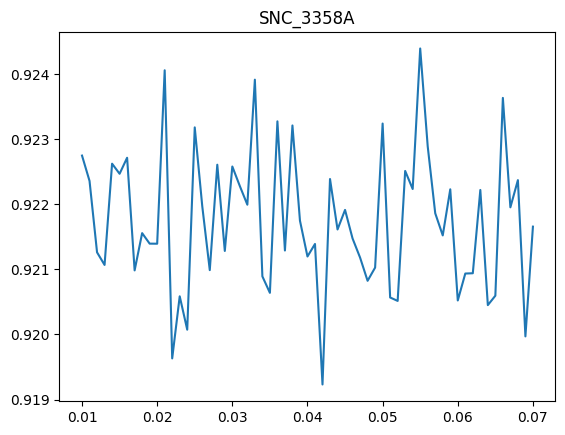

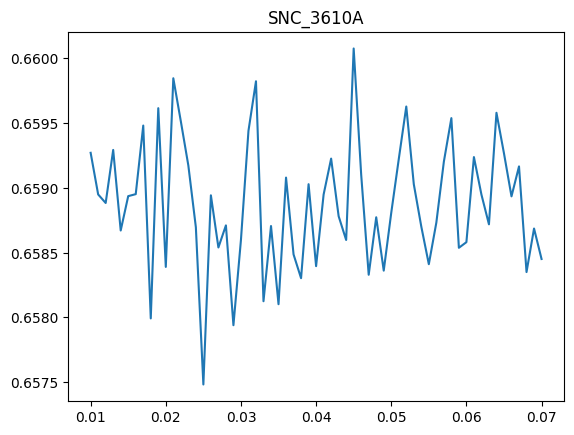

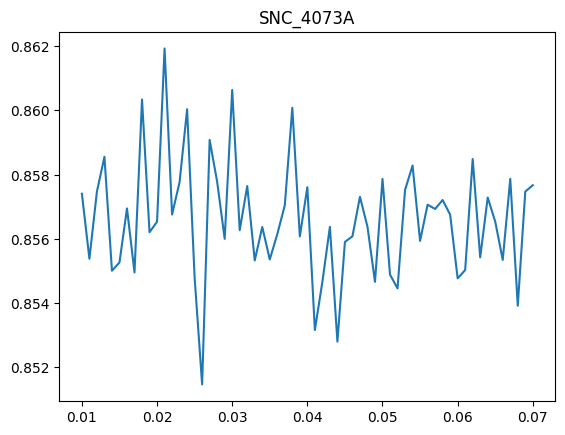

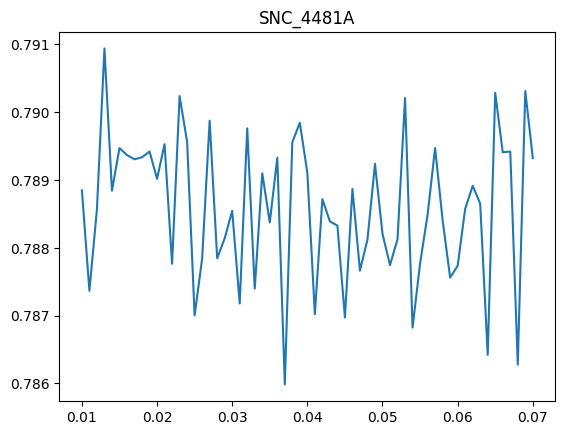

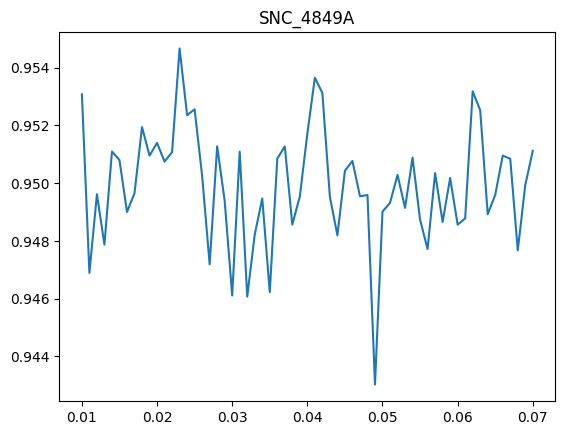

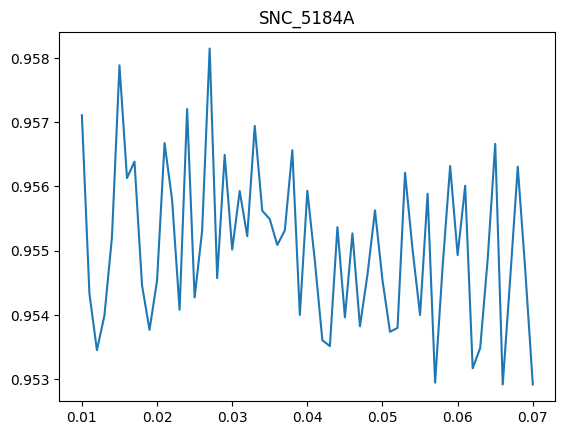

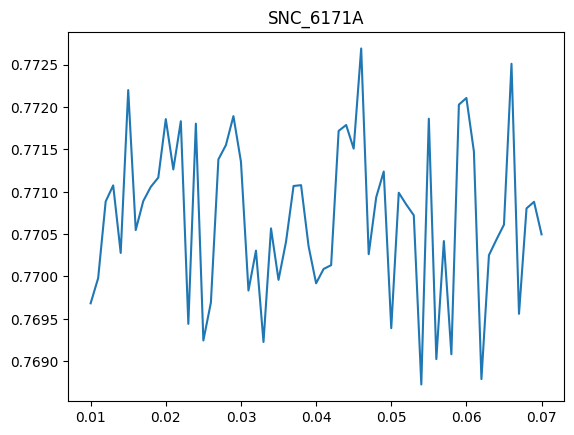

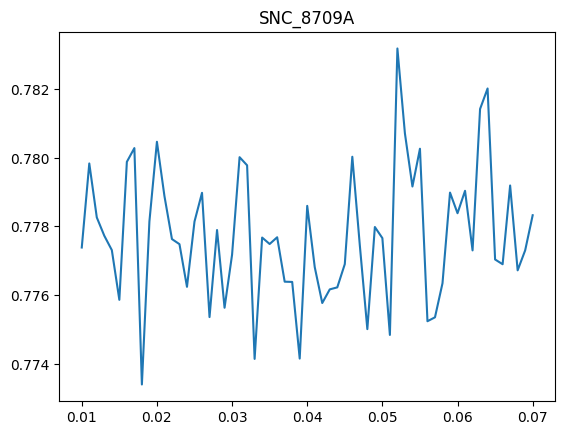

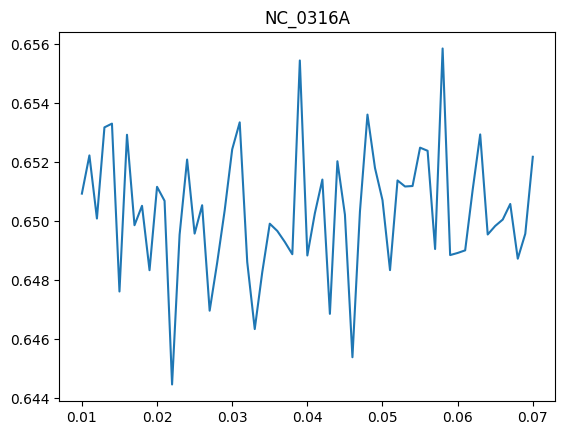

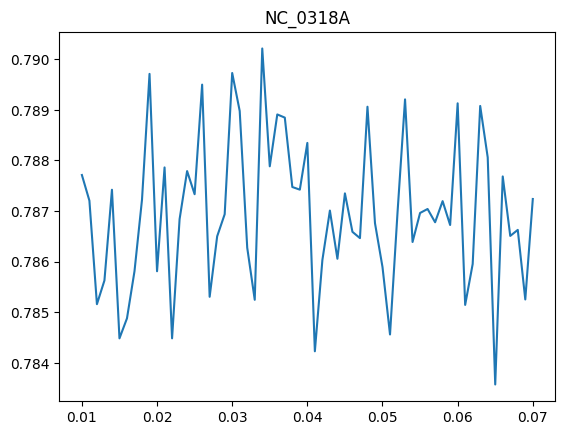

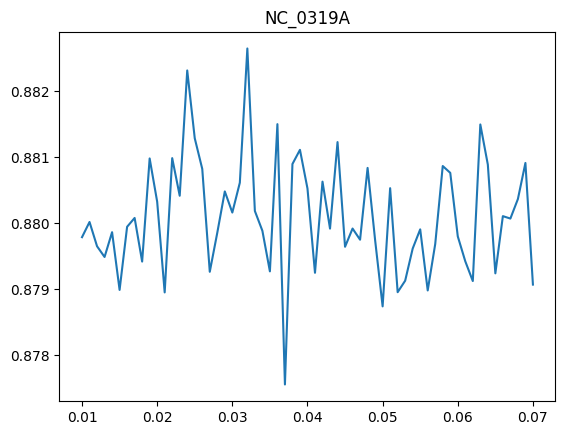

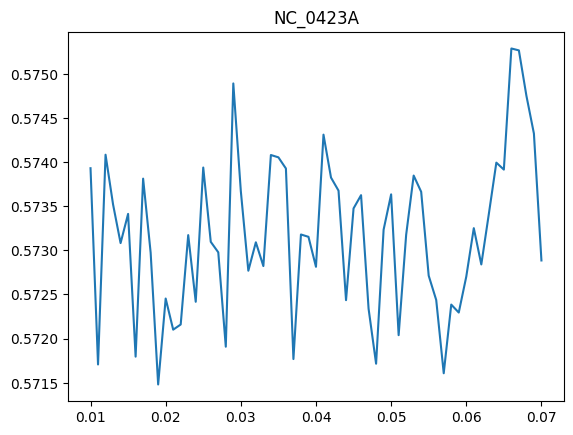

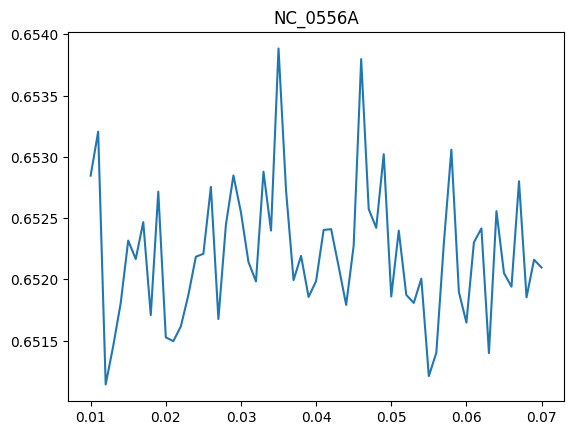

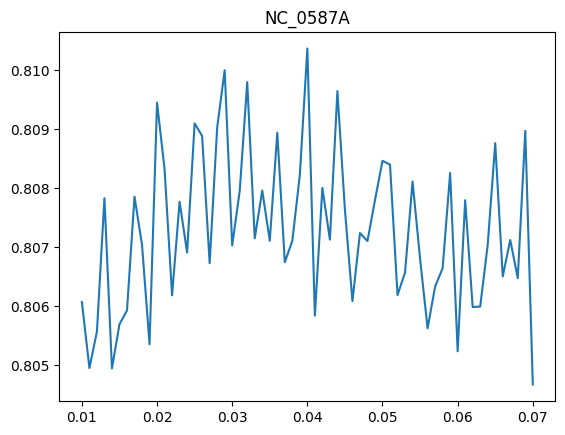

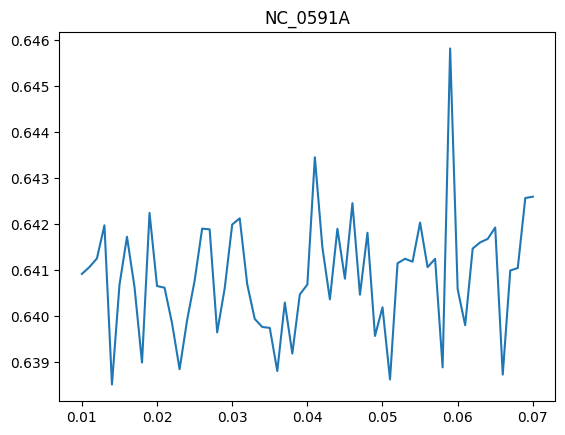

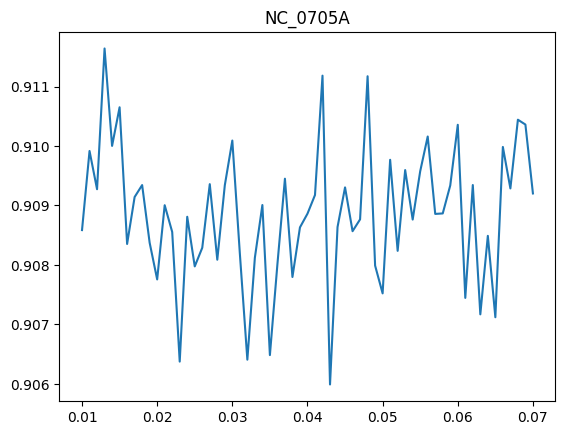

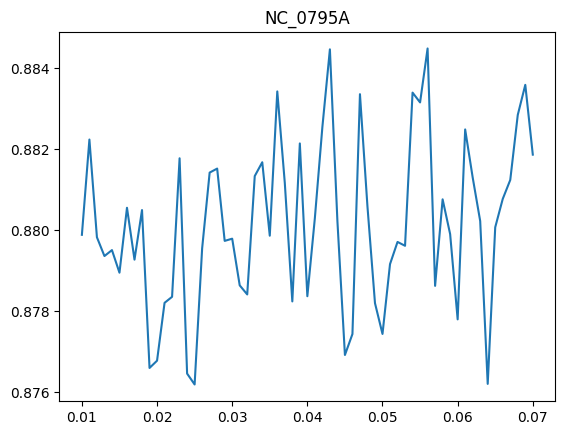

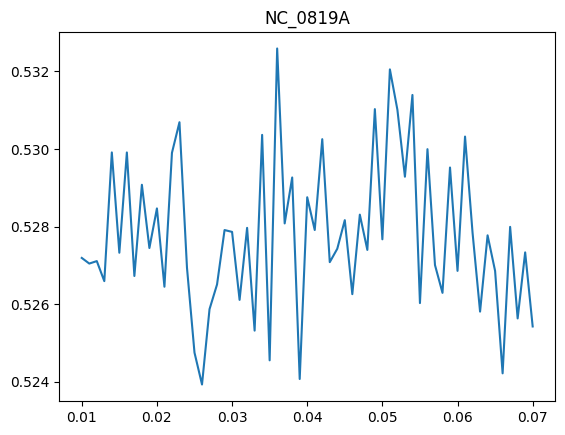

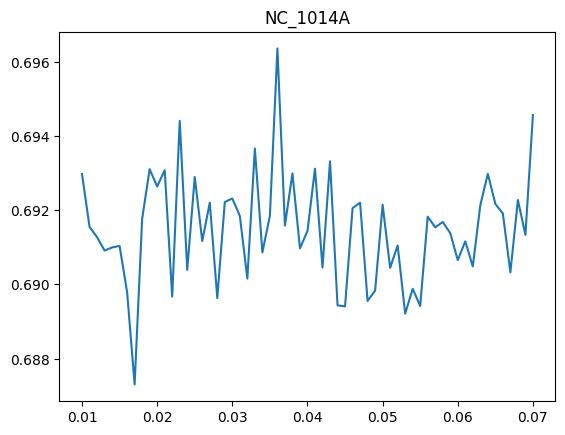

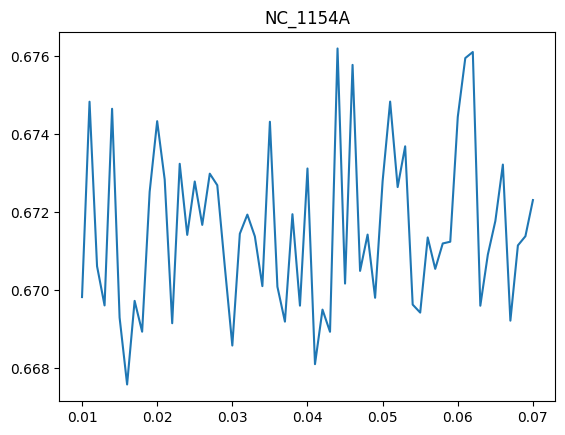

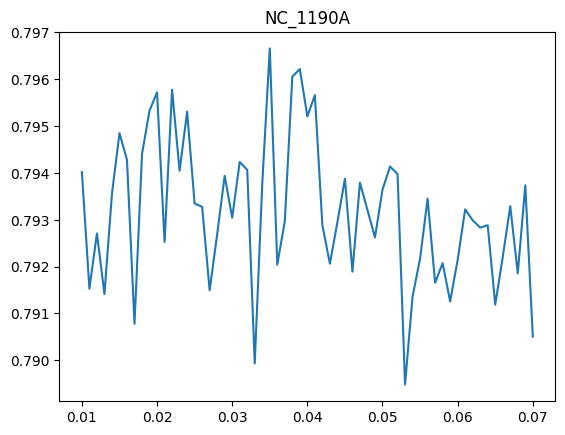

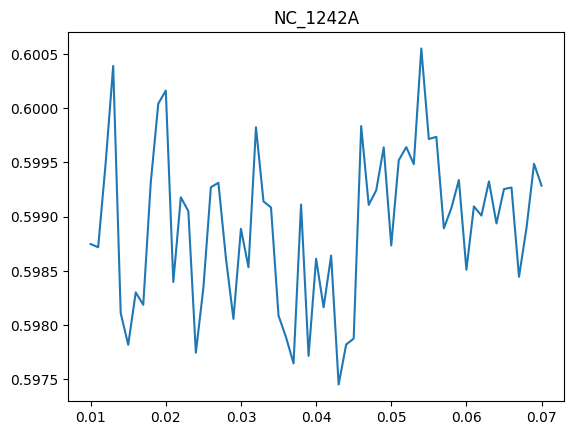

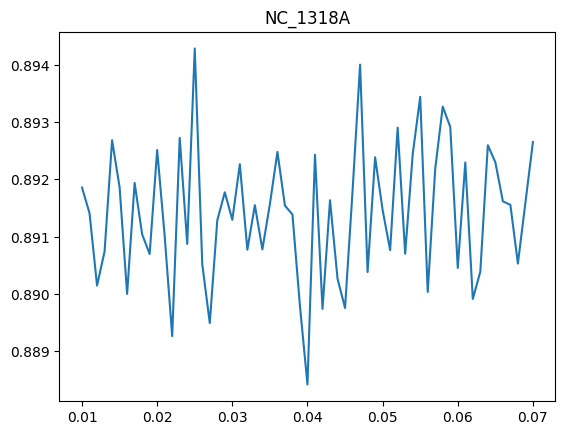

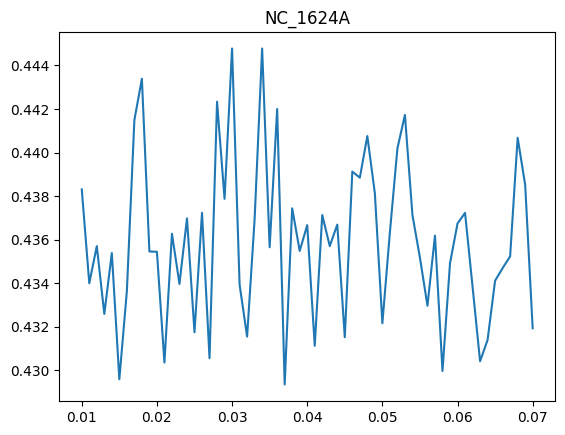

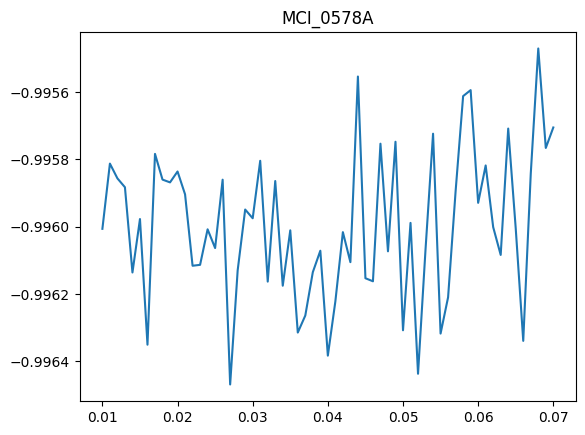

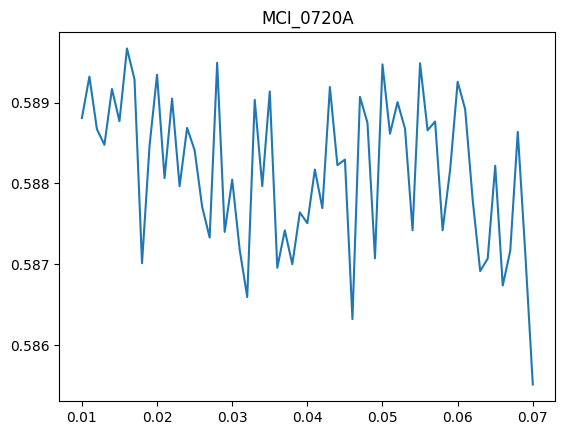

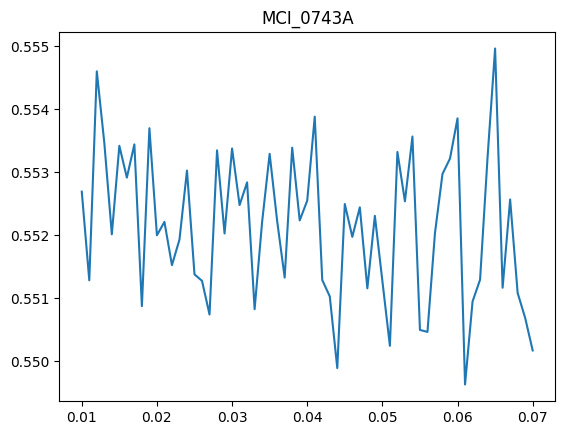

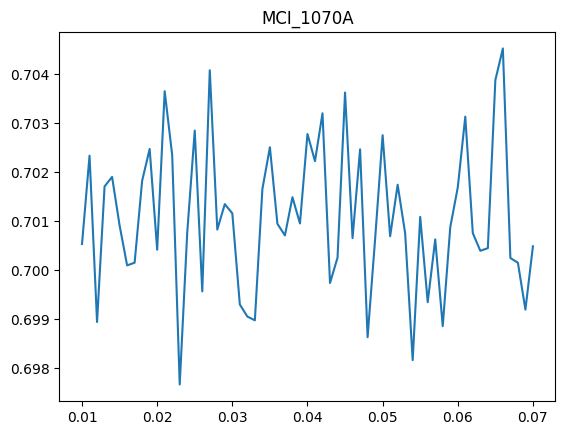

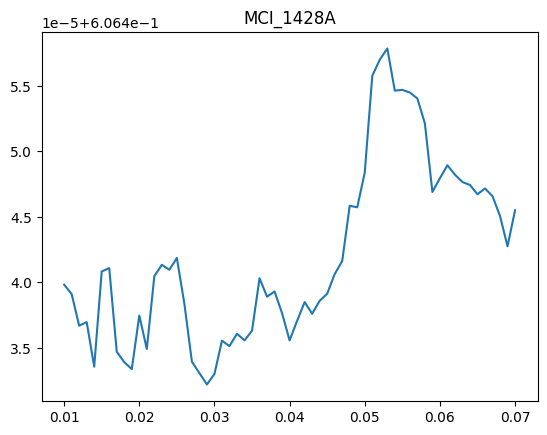

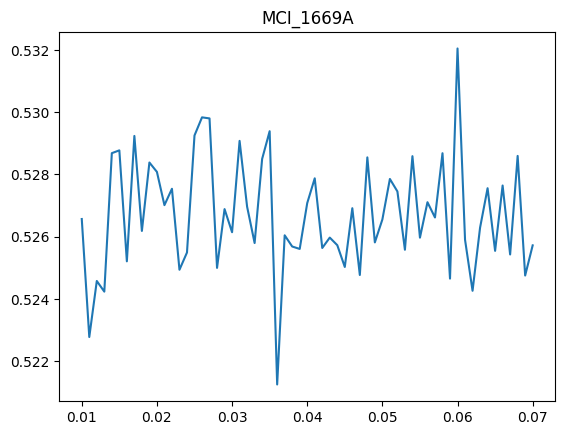

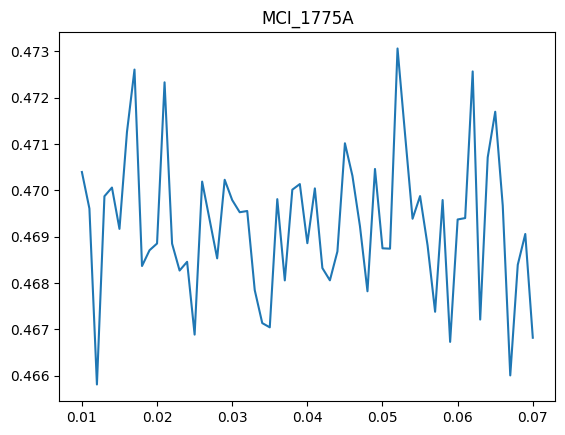

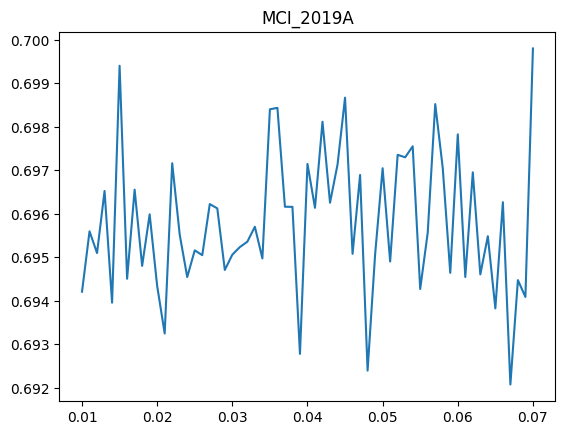

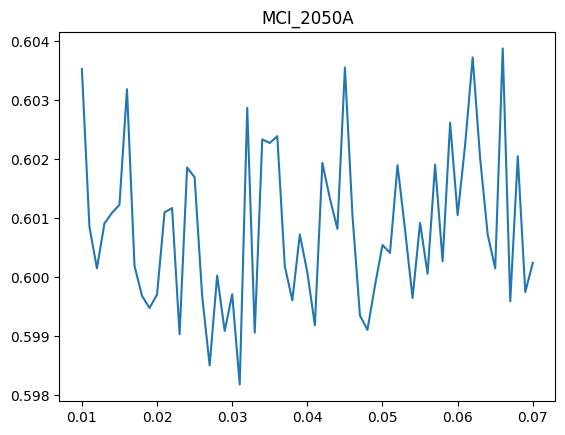

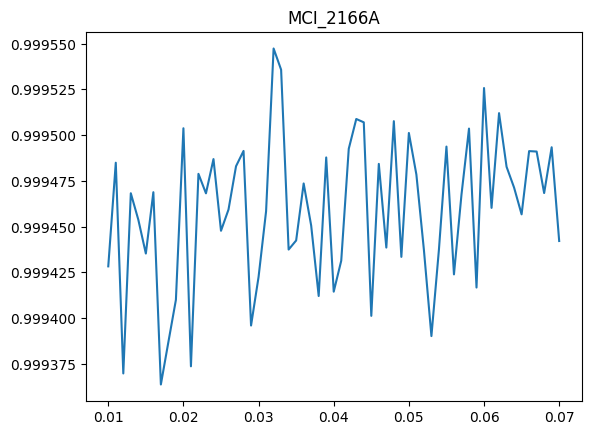

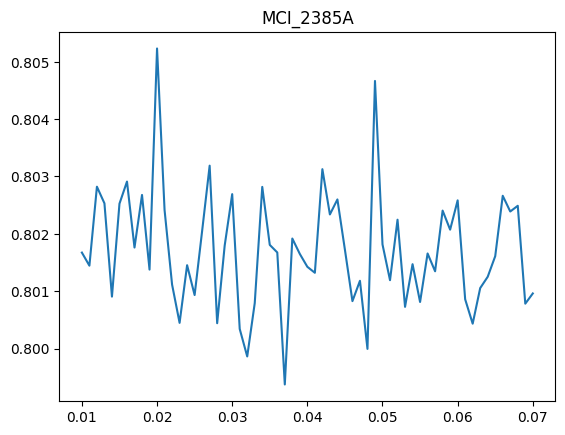

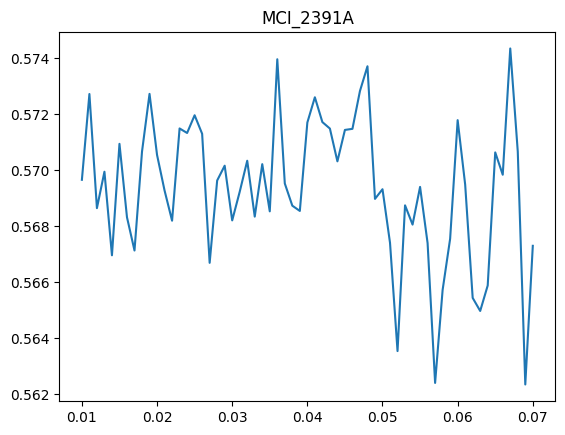

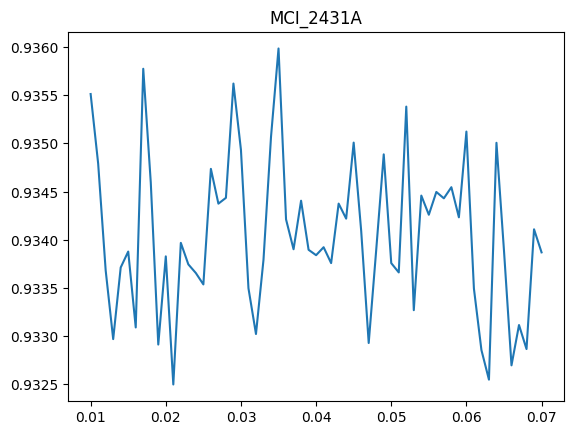

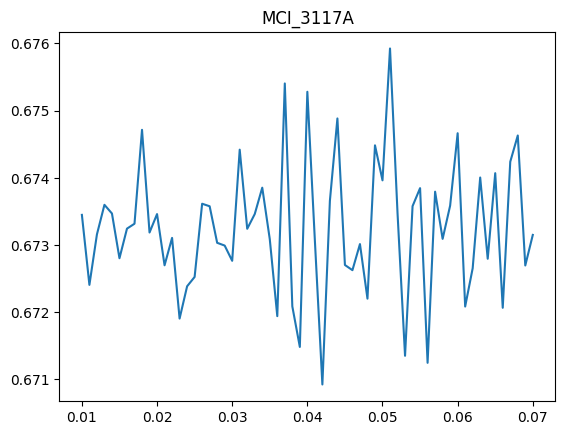

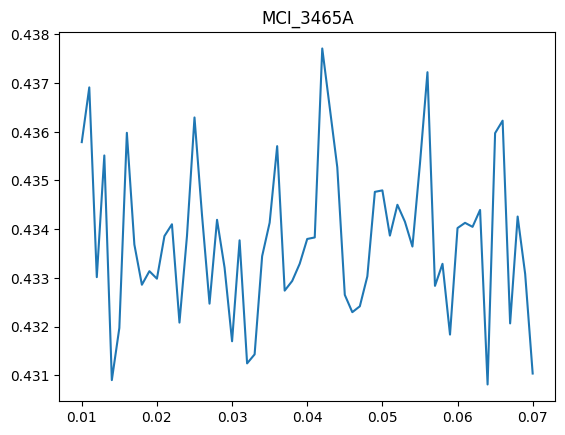

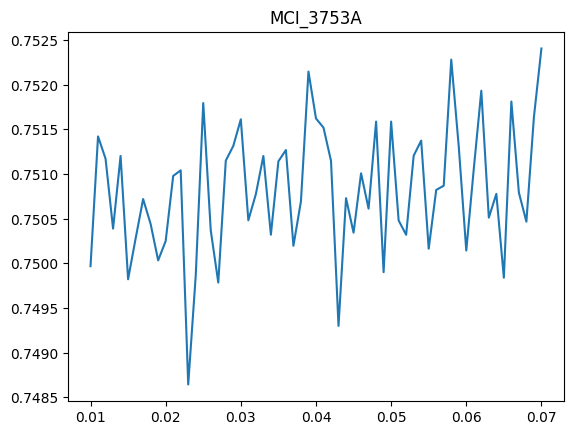

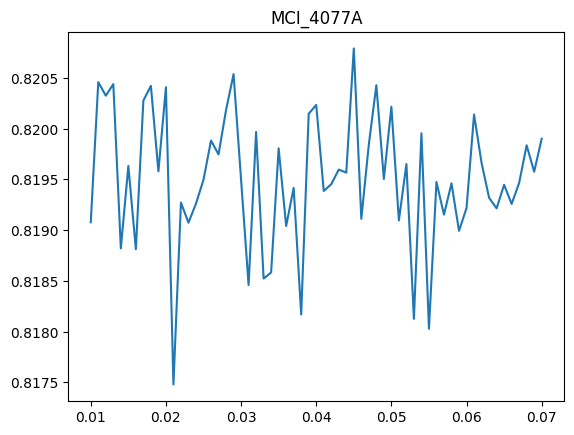

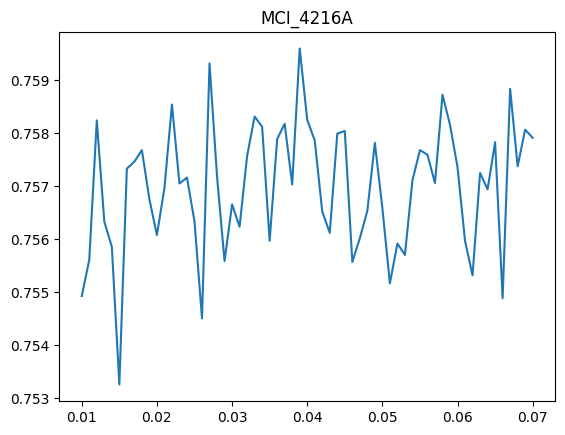

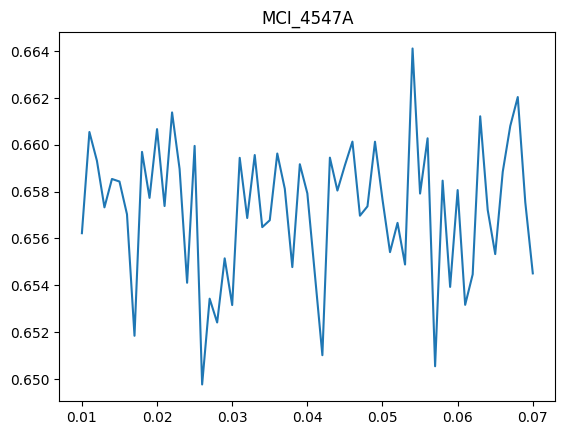

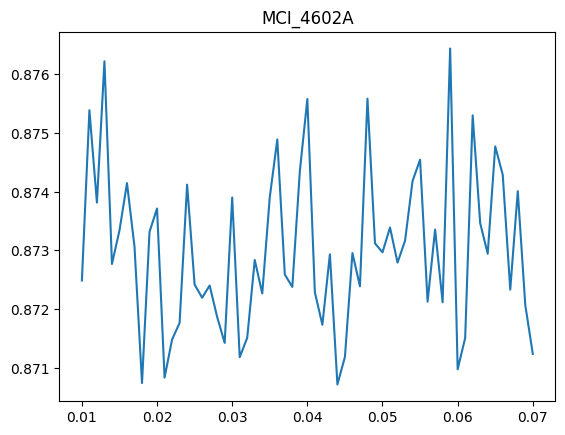

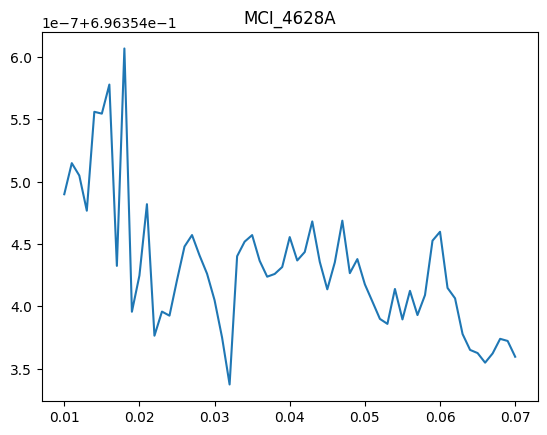

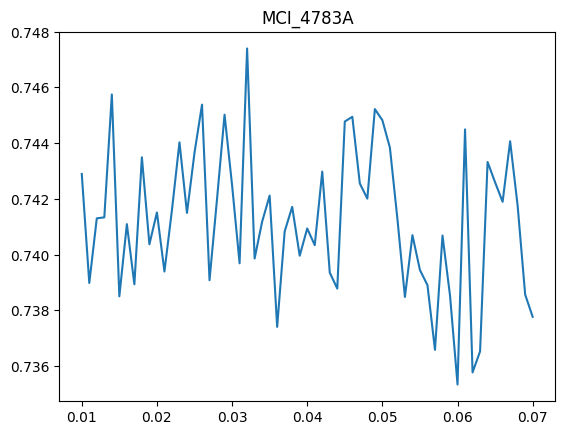

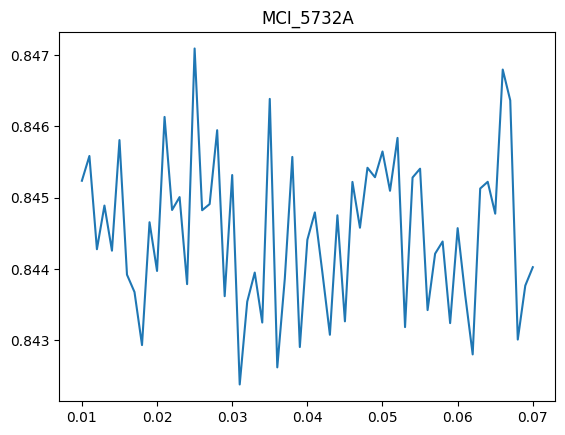

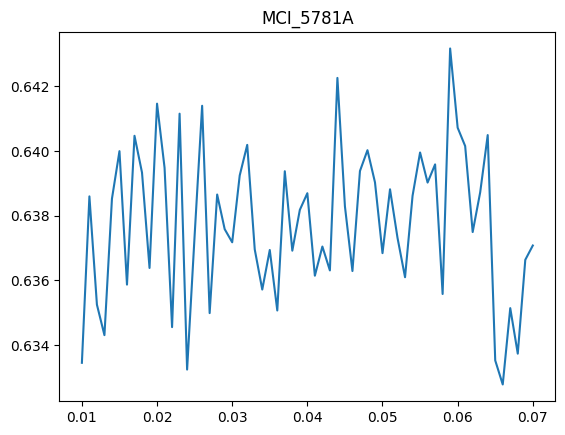

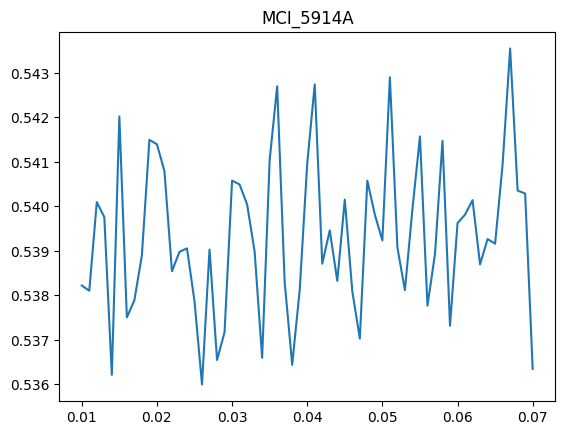

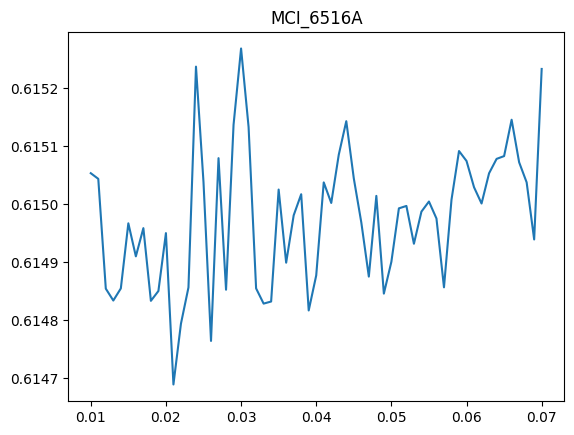

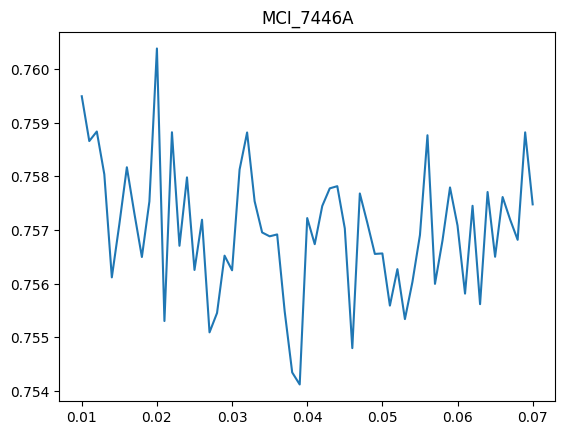

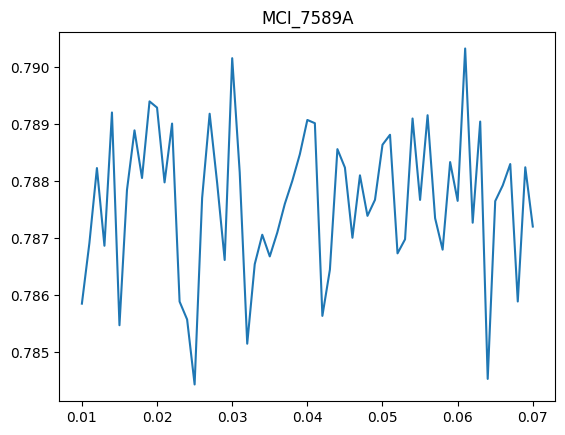

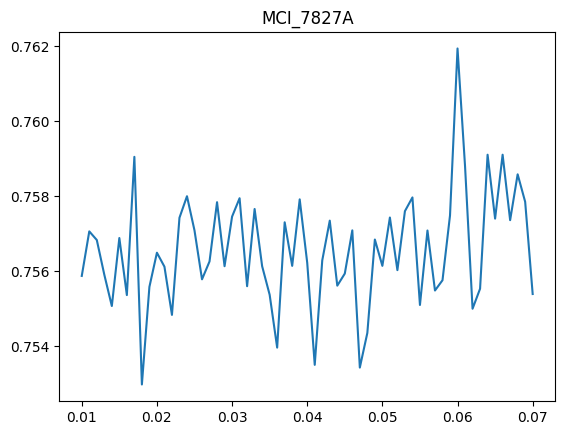

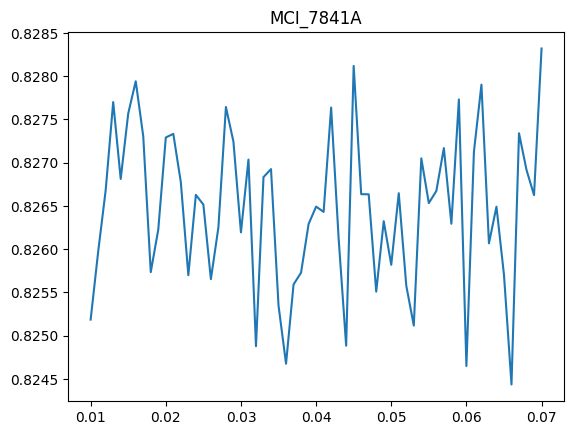

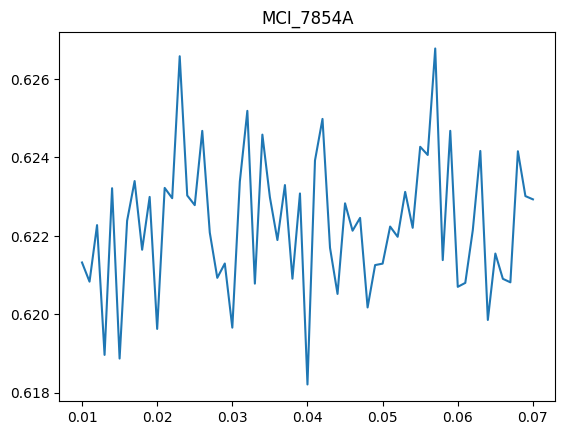

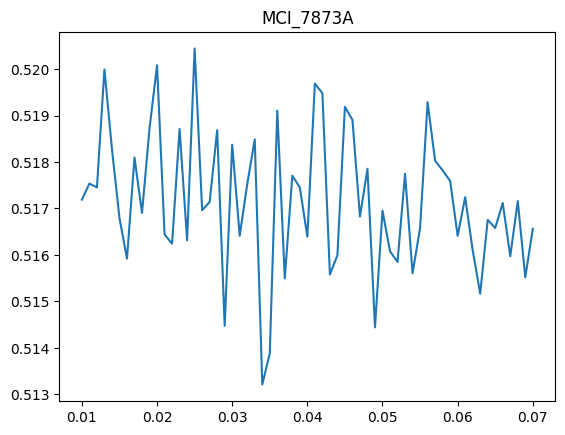

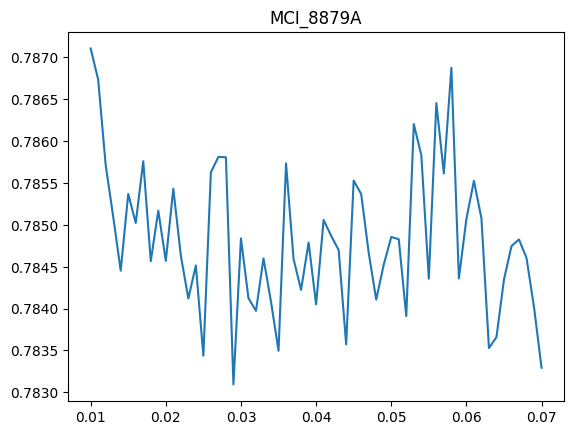

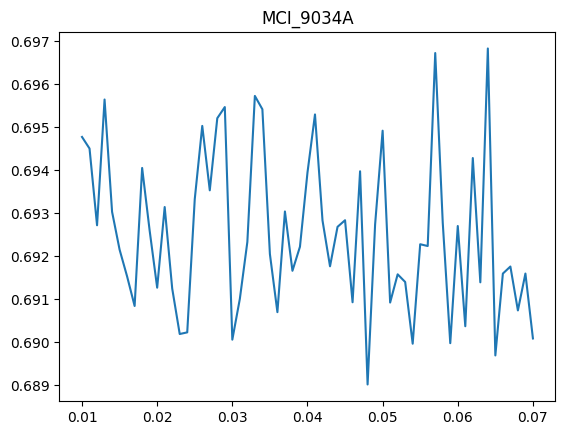

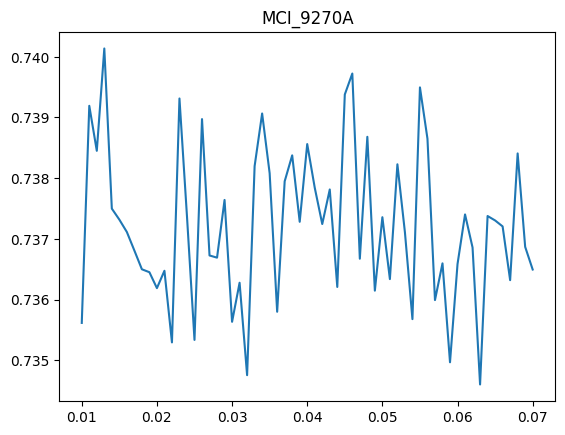

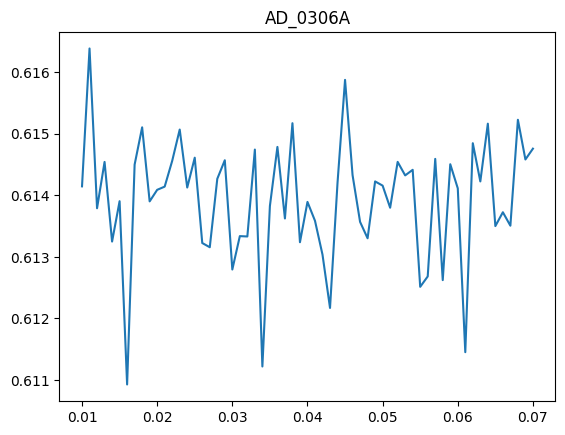

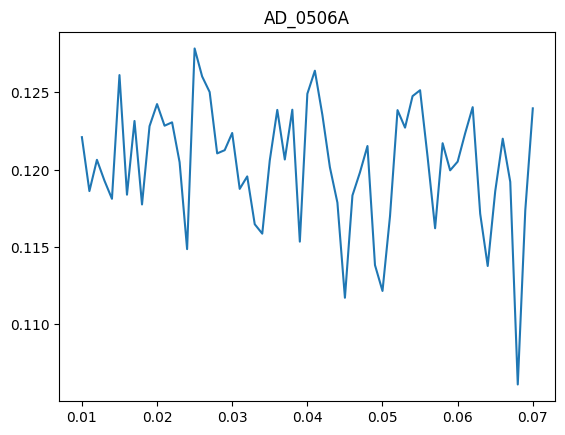

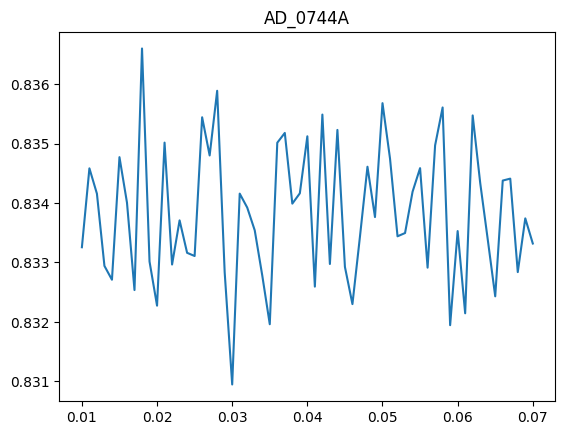

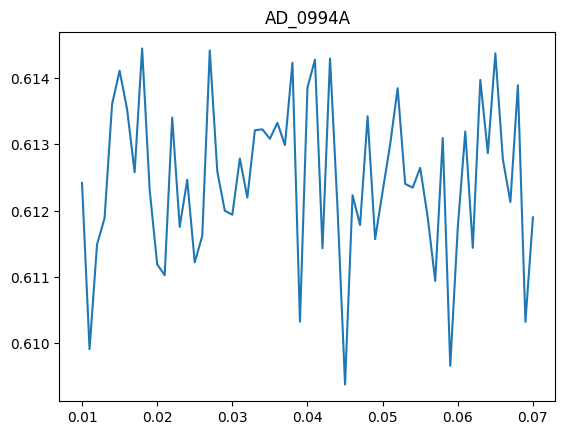

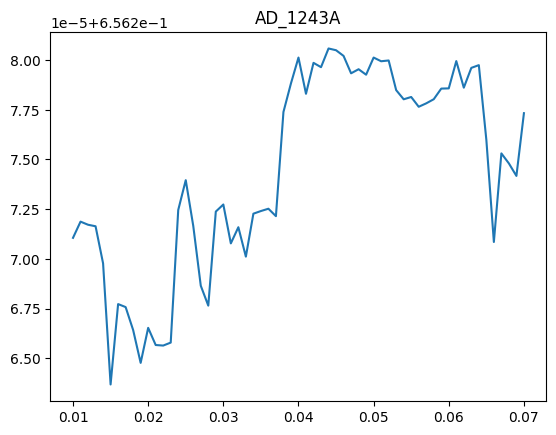

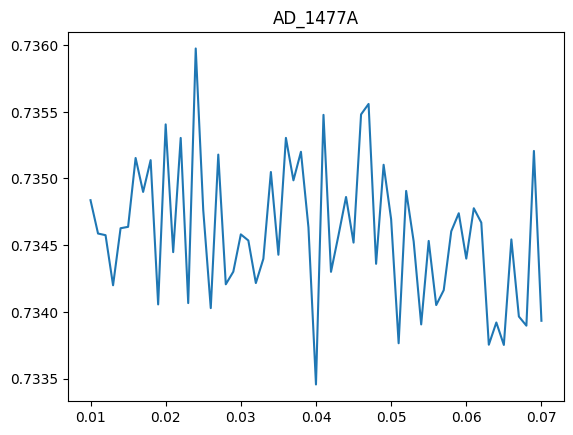

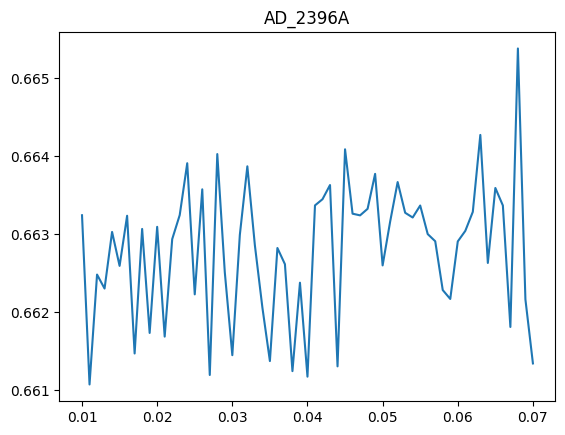

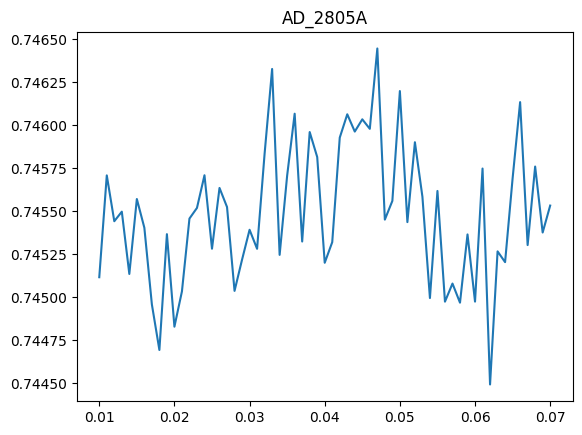

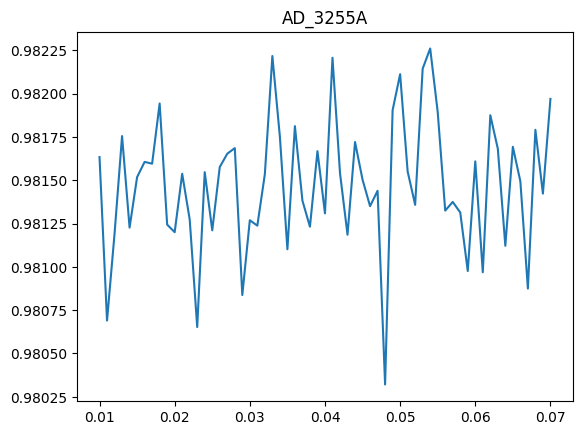

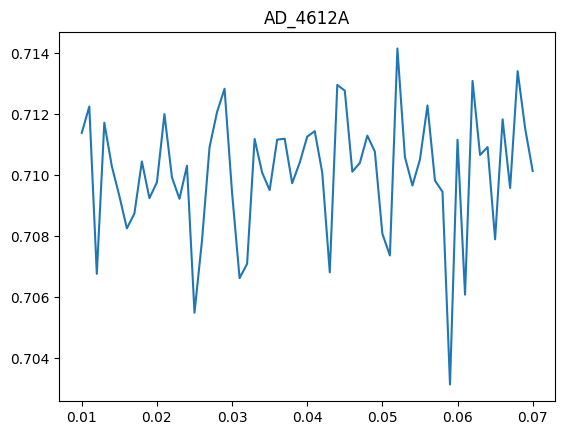

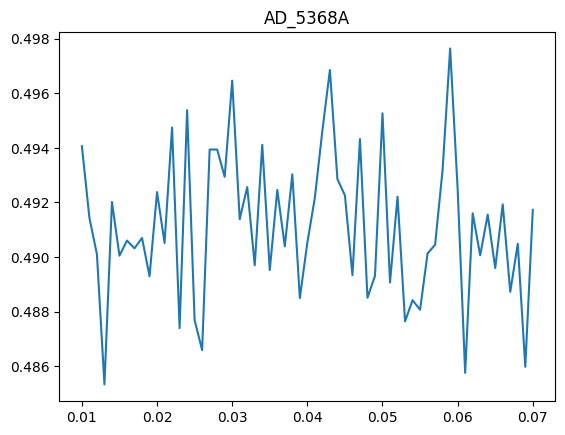

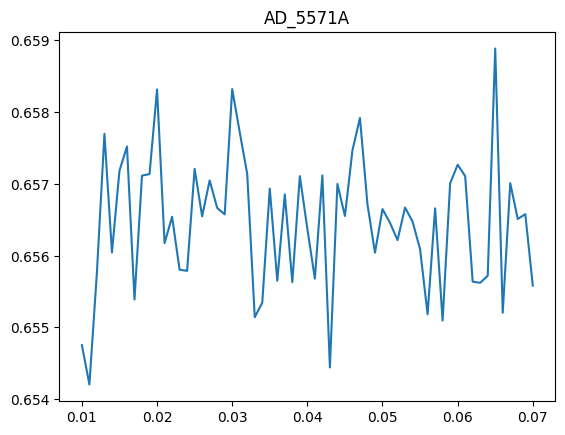

In [2]:
base_dir = "/Users/yilewang/Downloads/"
data_dir = pjoin(base_dir, "local_inhibition")

eFC_dir = "/Users/yilewang/workspaces/data4project/lateralization/ts_fmri/fmri_AAL_16"

def FC_fitting(group, caseid, K21, dir):
    subj_dir = pjoin(dir, group, caseid+'_'+str(K21)+'.csv')
    s_ts = pd.read_csv(subj_dir)
    # calculate the simulated FC
    s_fc = s_ts.corr()
    # compare it to the empirical FC
    mat = scipy.io.loadmat(pjoin(eFC_dir, group+"-TS", caseid, "ROISignals_"+caseid+'.mat'))
    e_ts = pd.DataFrame(mat['ROISignals'])
    e_fc = e_ts.corr()
    # vectorize the lower triangle of the matrix
    s_fc_vec = np.tril(s_fc, k=-1)[np.nonzero(np.tril(s_fc, k=-1))[0]]
    e_fc_vec = np.tril(e_fc, k=-1)[np.nonzero(np.tril(e_fc, k=-1))[0]]
    # calculate the correlation coefficient
    corr = np.corrcoef(s_fc_vec, e_fc_vec)[0,1]
    # iterate then I can have a plot for inidividuals.
    return corr

# read mega data
mega_data = pd.read_excel('/Users/yilewang/workspaces/data4project/mega_table.xlsx', sheet_name='tvb_parameters')

# create a dataframe for all subjects
local_inhibition = pd.DataFrame(columns=['group', 'caseid', 'highest_K21', 'highest_corr', 'average_corr'])
for i, j in zip(mega_data.group, mega_data.caseid):
    k_corr = []
    for k in np.arange(0.01, 0.071, 0.001):
        k = round(k, 3)
        try:
            corr = FC_fitting(i, j, k, data_dir)
            k_corr.append(corr)
        except:
            continue
    # find the highest correlation coefficient
    if len(k_corr)>0:
        highest_K21 = np.arange(0.01, 0.071, 0.001)[np.argmax(k_corr)]
        highest_corr = np.max(k_corr)
        average_corr = np.mean(k_corr)
        if j == "0578A":
            pass
        else:
            local_inhibition.loc[len(local_inhibition)] = [i, j, highest_K21, highest_corr, average_corr]
    else:
        pass
    if len(k_corr)>0:
        plt.plot(np.arange(0.01, 0.071, 0.001),k_corr)
        plt.title(f"{i}_{j}")
        plt.show()
    else:
        pass

<Axes: xlabel='group', ylabel='highest_K21'>

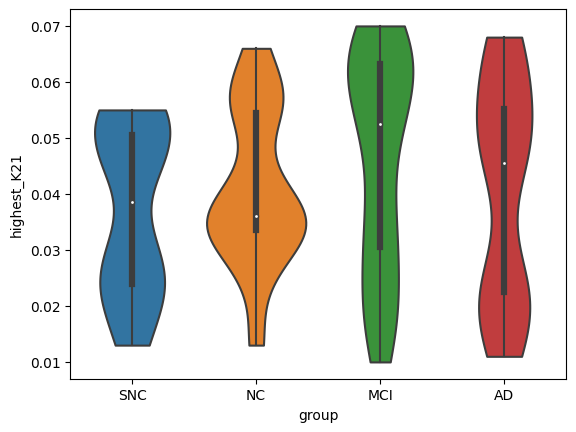

In [3]:
# plot the distribution of highest_K21 across different groups
seaborn.violinplot(x='group', y='highest_K21', data=local_inhibition, cut=0, bw=.4)

<Axes: xlabel='group', ylabel='highest_corr'>

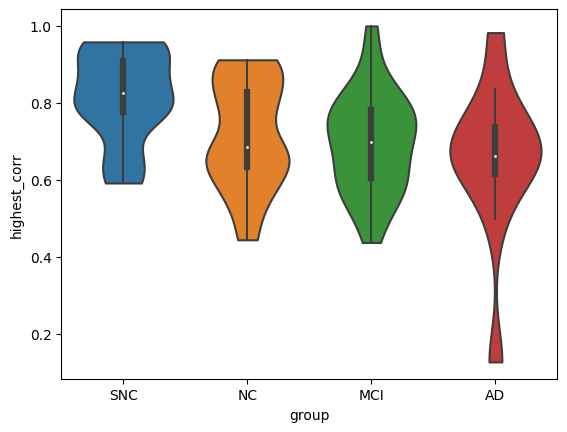

In [4]:
seaborn.violinplot(x='group', y='highest_corr', data=local_inhibition, cut=0, bw=0.4)

<Axes: xlabel='group', ylabel='average_corr'>

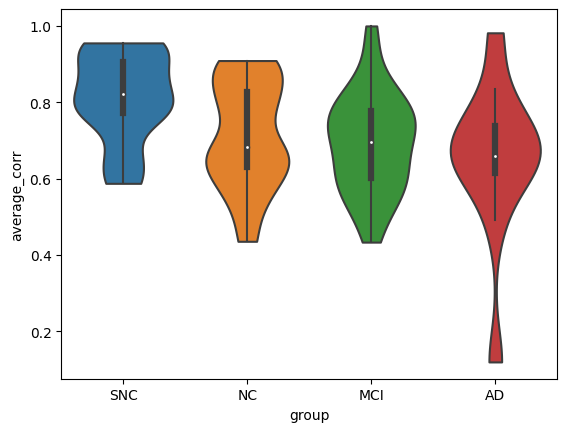

In [5]:
seaborn.violinplot(x='group', y='average_corr', data=local_inhibition, cut=0, bw=0.4)